<a href="https://colab.research.google.com/github/RaamVijith/Dengue_forecasting_MachineLearnig_Algorithms-/blob/main/LSTM_Dengue_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

%cd /mydrive/dataset/

df1 = pd.read_csv("Dengue_Data_colombo.csv")
df2 = pd.read_csv("timeseries_data_colombo.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
 appsheet			  'IMG_E0085Lo Qulty.jpg'
 Classroom			  'IMG_E0087lo Qulty.jpg'
'Colab Notebooks'		  'Mini Project final presentation template(2022).pptx'
 CV_Ramalingam_Vijithan.pdf	  'My Drive'
 dataset			   Research
 IMG_20211006_1048181111sign.jpg
/content/gdrive/My Drive/dataset


In [38]:
df1.head()

,Date,City,Value
0,1/1/2010,Colombo,584
1,2/1/2010,Colombo,606
2,3/1/2010,Colombo,294
3,4/1/2010,Colombo,224
4,5/1/2010,Colombo,296


In [39]:
df2.head()

,time,temperature_2m_mean,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,1/1/2010,26.1,29.2,0.0,0.0,0,0,11.7,27.4,20,4.58,7,79.899994,16,Sri Lanka,Colombo
1,2/1/2010,26.5,31.0,17.1,17.1,0,8,11.6,25.9,41,3.61,7,79.899994,16,Sri Lanka,Colombo
2,3/1/2010,28.1,32.5,0.0,0.0,0,0,13.0,28.4,248,5.35,7,79.899994,16,Sri Lanka,Colombo
3,4/1/2010,27.6,33.5,5.5,5.5,0,13,13.6,30.2,231,4.20,7,79.899994,16,Sri Lanka,Colombo
4,5/1/2010,27.9,34.1,6.8,6.8,0,10,10.3,24.5,295,4.32,7,79.899994,16,Sri Lanka,Colombo


In [40]:
dataset=pd.merge(df1,df2,left_on="Date",right_on="time")


In [41]:
dataset = dataset[['Date','Value','temperature_2m_mean','rain_sum','windspeed_10m_max']]
dataset.tail(30)

,Date,Value,temperature_2m_mean,rain_sum,windspeed_10m_max
124,7/1/2020,324,27.1,2.6,11.9
125,8/1/2020,231,26.3,18.7,17.1
126,9/1/2020,192,25.4,31.3,13.3
127,10/1/2020,151,27.1,1.4,20.8
128,11/1/2020,59,27.1,0.1,10.5
129,12/1/2020,92,26.1,2.1,21.7
130,1/1/2021,1325,26.1,0.0,14.4
131,2/1/2021,792,28.7,0.0,14.2
132,3/1/2021,815,28.2,0.4,10.1
133,4/1/2021,579,28.8,0.0,16.4


In [42]:
# Data preprocessing
scaler = StandardScaler()
data = scaler.fit_transform(dataset[['Value', 'temperature_2m_mean', 'rain_sum', 'windspeed_10m_max']])

In [43]:
# Create sequences for training
def create_multivariate_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 15
X, y = create_multivariate_sequences(data, seq_length)

# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [44]:
# Build the multivariate LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dense(y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')


In [45]:

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Make Train and Test Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the scaled data to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Evaluate the model
train_score = np.sqrt(mean_squared_error(scaler.inverse_transform(y_train), train_predict))
test_score = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), test_predict))

print(f"Train RMSE: {train_score:.2f}")
print(f"Test RMSE: {test_score:.2f}")



Epoch 1/100
2/2 [==============================] - 2s 25ms/step - loss: 0.9442
Epoch 2/100
2/2 [==============================] - 0s 20ms/step - loss: 0.9325
Epoch 3/100
2/2 [==============================] - 0s 19ms/step - loss: 0.9209
Epoch 4/100
2/2 [==============================] - 0s 19ms/step - loss: 0.9127
Epoch 5/100
2/2 [==============================] - 0s 18ms/step - loss: 0.9021
Epoch 6/100
2/2 [==============================] - 0s 22ms/step - loss: 0.8933
Epoch 7/100
2/2 [==============================] - 0s 14ms/step - loss: 0.8862
Epoch 8/100
2/2 [==============================] - 0s 16ms/step - loss: 0.8773
Epoch 9/100
2/2 [==============================] - 0s 14ms/step - loss: 0.8692
Epoch 10/100
2/2 [==============================] - 0s 14ms/step - loss: 0.8611
Epoch 11/100
2/2 [==============================] - 0s 14ms/step - loss: 0.8530
Epoch 12/100
2/2 [==============================] - 0s 13ms/step - loss: 0.8448
Epoch 13/100
2/2 [==============================]

In [46]:
# Make a 90-day forecast
forecast_input = data[-seq_length:].reshape(1, seq_length, -1)
forecast = []
for _ in range(90):
    next_day = model.predict(forecast_input)
    forecast.append(next_day[0])
    forecast_input = np.append(forecast_input[:, 1:, :], next_day[0].reshape(1, 1, -1), axis=1)

# Inverse transform the forecasted data
forecast = scaler.inverse_transform(np.array(forecast))

# Create date ranges for Train Predictions, Test Predictions, and Forecast
train_dates = dataset['Date'][:train_size]
test_dates = dataset['Date'][train_size:train_size + len(y_test)]


1/1 [==============================] - 0s 30ms/step


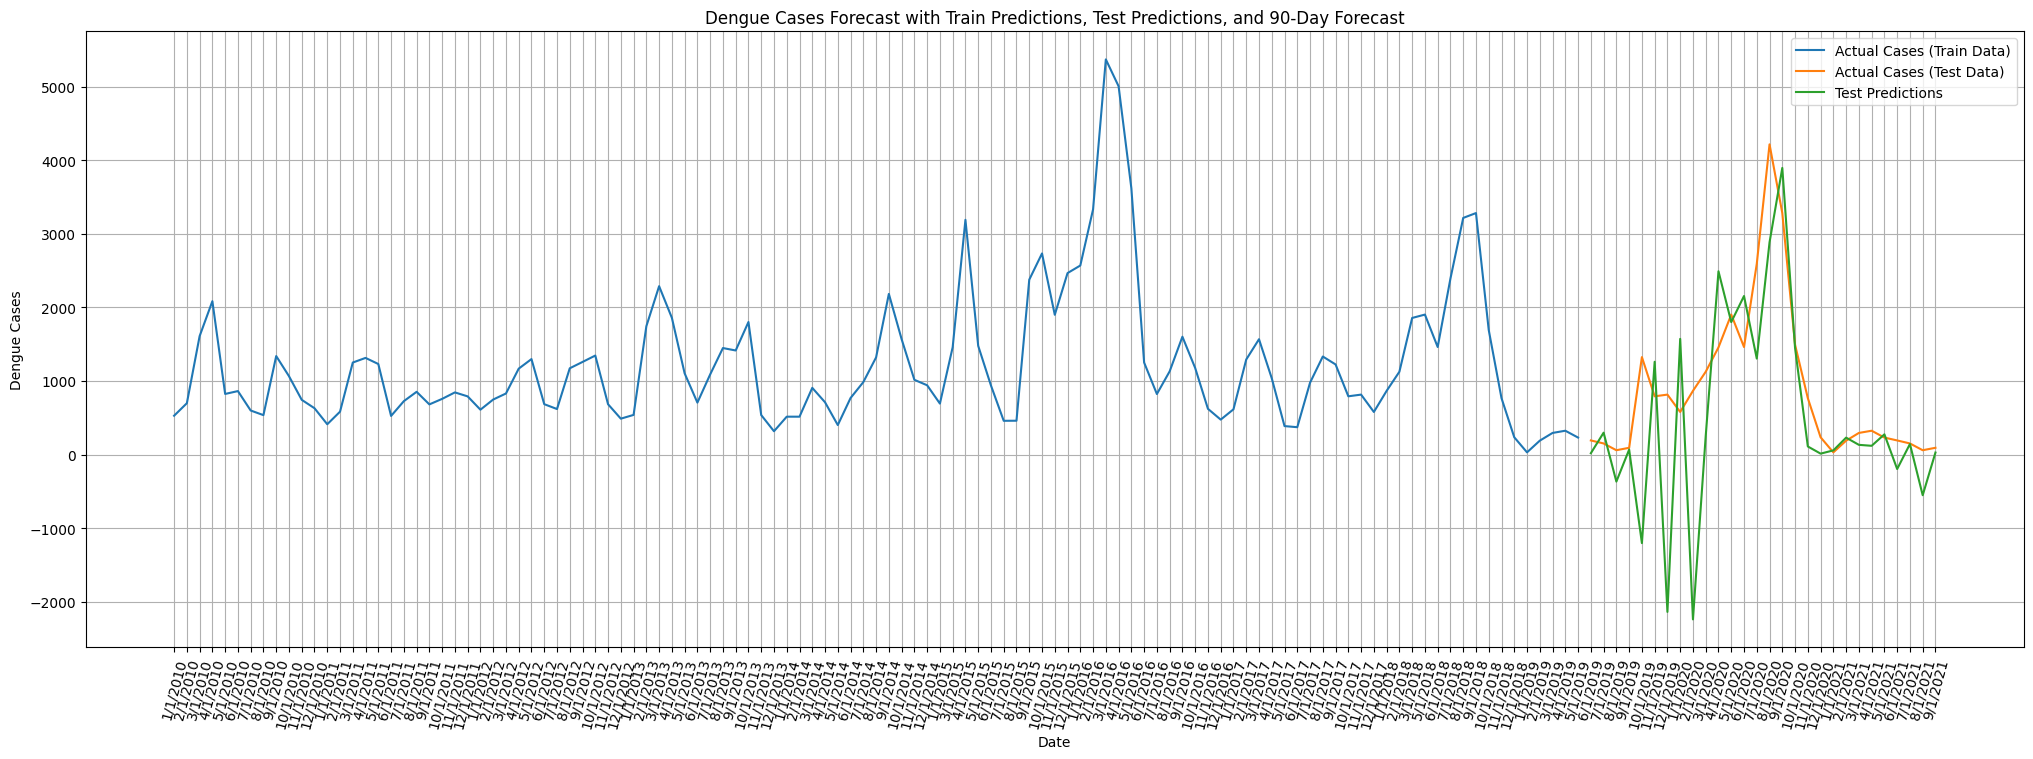

In [57]:
# Plot Train Predictions, Test Predictions, and 90-Day Forecast in one graph
fig, ax = plt.subplots(1, figsize = (25, 8))
ax.grid()
plt.xticks(rotation = 85)
plt.plot(train_dates, scaler.inverse_transform(y_train)[:, 0], label="Actual Cases (Train Data)")
plt.plot(test_dates, scaler.inverse_transform(y_test)[:, 0], label="Actual Cases (Test Data)")
plt.plot(test_dates, test_predict[:, 0], label="Test Predictions")
#plt.plot(forecast_dates, forecast[:, 0], label="90-Day Forecast")



plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.title('Dengue Cases Forecast with Train Predictions, Test Predictions, and 90-Day Forecast')
plt.legend()
plt.setp(ax.get_xticklabels(), rotation = 75)

plt.show()

In [48]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(scaler.inverse_transform(y_test), test_predict)
rmse = np.sqrt(mse)


In [49]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(scaler.inverse_transform(y_test), test_predict)


In [50]:
from sklearn.metrics import r2_score

# Calculate R-squared (R2)
r2 = r2_score(scaler.inverse_transform(y_test), test_predict)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 298598.95
Root Mean Squared Error (RMSE): 546.44
Mean Absolute Error (MAE): 176.22
R-squared (R2): -2.23
